In [ ]:
# ML-Vraagstuk: Wat bepaalt de prijs van een huidverzorgingsproduct?
# Door: Djoeke Duijker en Marjon Phu

In [ ]:
# IMPORTEREN LIBRARIES

In [30]:
# Importeren van de libraries met versienummer
import pandas as pd  # Versie 1.5.3
import numpy as np  # Versie 1.24.2
import matplotlib.pyplot as plt  # Versie 3.7.1
import seaborn as sns  # Versie 0.12.2
from sklearn.linear_model import LinearRegression  # scikit-learn Versie 1.2.2
from sklearn.tree import DecisionTreeRegressor  # scikit-learn Versie 1.2.2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from rapidfuzz import process  # Versie 2.13.1
import re

In [ ]:
# IMPORTEREN DATASETS

In [31]:
# Importeren datasets
skincare_data = pd.read_csv('../data/skincare_products_clean.csv')
inci_data = pd.read_csv('../data/ingredients_list.csv')
# Toon de eerste paar rijen van elke dataset
print("Skincare Dataset:")
print(skincare_data.head())

print("INCI Dataset:")
print(inci_data.head())

Skincare Dataset:
                                        product_name  \
0  The Ordinary Natural Moisturising Factors + HA...   
1      CeraVe Facial Moisturising Lotion SPF 25 52ml   
2  The Ordinary Hyaluronic Acid 2% + B5 Hydration...   
3          AMELIORATE Transforming Body Lotion 200ml   
4                     CeraVe Moisturising Cream 454g   

                                         product_url product_type  \
0  https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser   
1  https://www.lookfantastic.com/cerave-facial-mo...  Moisturiser   
2  https://www.lookfantastic.com/the-ordinary-hya...  Moisturiser   
3  https://www.lookfantastic.com/ameliorate-trans...  Moisturiser   
4  https://www.lookfantastic.com/cerave-moisturis...  Moisturiser   

                                       clean_ingreds   price  
0  ['capric triglyceride', 'cetyl alcohol', 'prop...   £5.20  
1  ['homosalate', 'glycerin', 'octocrylene', 'eth...  £13.00  
2  ['sodium hyaluronate', 'sodium hyaluro

In [ ]:
# DATASETS INSPECTEREN

In [32]:
# Inspecteer de structuur van de datasets en zoek naar missende waarden
print("\nInfo Skincare Dataset:")
print(skincare_data.info())

print("\nInfo INCI Dataset:")
print(inci_data.info())

# Controleer op duplicate values
print("\nAantal duplicaten in Skincare Dataset:")
print(skincare_data.duplicated().sum())



Info Skincare Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_name   1138 non-null   object
 1   product_url    1138 non-null   object
 2   product_type   1138 non-null   object
 3   clean_ingreds  1138 non-null   object
 4   price          1138 non-null   object
dtypes: object(5)
memory usage: 44.6+ KB
None

Info INCI Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   name                247 non-null    object
 1   scientific_name     1 non-null      object
 2   short_description   247 non-null    object
 3   what_is_it          247 non-null    object
 4   what_does_it_do     247 non-null    object
 5   who_is_it_good_for  248 non-null    object
 6   who_should

In [ ]:
# OPSCHONEN DATASET

In [37]:
# Controleer of de kolom voor prijs in GBP bestaat
if 'price' in skincare_data.columns:
    # Verwijder het £-teken en converteer naar float
    skincare_data['price'] = skincare_data['price'].str.replace('£', '', regex=False).astype(float)
    skincare_data['Price (EUR)'] = skincare_data['price'] * 1.15
else:
    print("Kolom 'price' ontbreekt in de dataset. Controleer de dataset.")

# Verwijder rijen met missende waarden in essentiële kolommen
skincare_data.dropna(subset=['clean_ingreds', 'Price (EUR)'], inplace=True)

# Verwijder duplicaten
skincare_data.drop_duplicates(inplace=True)

print("\nSkincare Dataset na opschoning:")
print(skincare_data.head())


Skincare Dataset na opschoning:
                                        product_name  \
0  The Ordinary Natural Moisturising Factors + HA...   
1      CeraVe Facial Moisturising Lotion SPF 25 52ml   
2  The Ordinary Hyaluronic Acid 2% + B5 Hydration...   
3          AMELIORATE Transforming Body Lotion 200ml   
4                     CeraVe Moisturising Cream 454g   

                                         product_url product_type  \
0  https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser   
1  https://www.lookfantastic.com/cerave-facial-mo...  Moisturiser   
2  https://www.lookfantastic.com/the-ordinary-hya...  Moisturiser   
3  https://www.lookfantastic.com/ameliorate-trans...  Moisturiser   
4  https://www.lookfantastic.com/cerave-moisturis...  Moisturiser   

                                       clean_ingreds  price         Brand  \
0  ['capric triglyceride', 'cetyl alcohol', 'prop...    5.2  The Ordinary   
1  ['homosalate', 'glycerin', 'octocrylene', 'eth...   13.0  

In [ ]:
# FEATURE ENGINEERING

In [54]:
# Voeg een kolom toe voor het merk, gebaseerd op productnamen
known_brands = [
    "The Ordinary", "Avene", "CeraVe", "Neutrogena", "L'Oréal", "Lancôme", "Weleda",
    "Aveeno", "La Roche-Posay", "Nivea", "Eucerin", "Garnier", "Clinique", "PIXI"
]

def extract_brand(product_name):
    for brand in known_brands:
        if brand.lower() in product_name.lower():
            return brand
    return "Unknown"

skincare_data['Brand'] = skincare_data['product_name'].apply(extract_brand)

print("\nUnieke Merken:")
print(skincare_data['Brand'].value_counts())




Unieke Merken:
Brand
Unknown           873
Clinique           46
La Roche-Posay     37
Garnier            33
L'Oréal            30
PIXI               29
The Ordinary       17
Lancôme            17
Weleda             14
CeraVe             13
Neutrogena         13
Avene               8
Aveeno              6
Eucerin             2
Name: count, dtype: int64


In [55]:
# DATA VERKENNEN

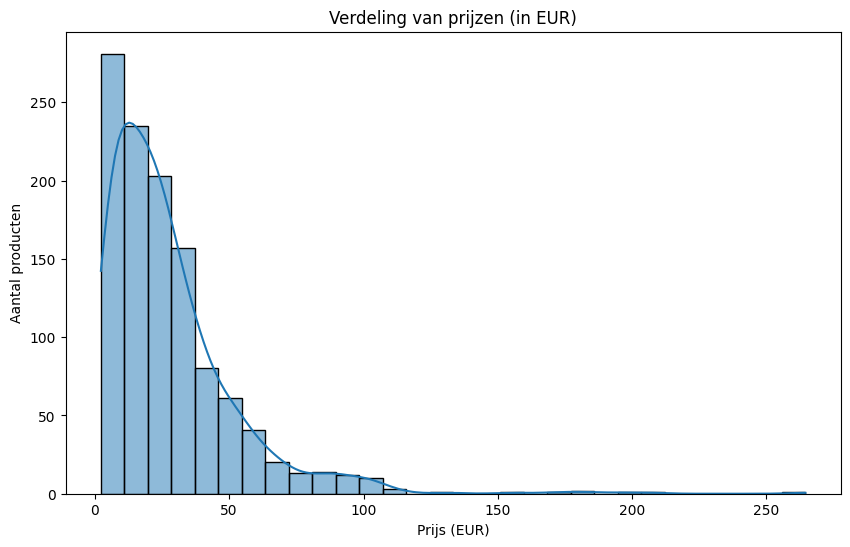

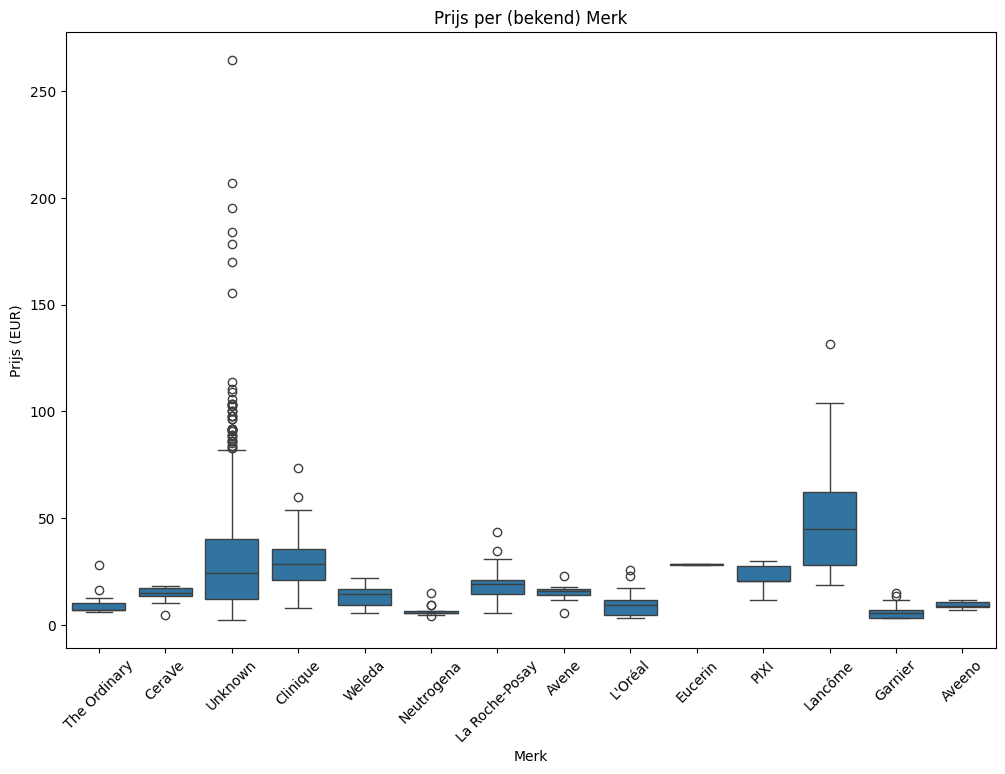

In [56]:
# Visualiseer de verdeling van prijzen
plt.figure(figsize=(10, 6))
sns.histplot(skincare_data['Price (EUR)'], kde=True, bins=30)
plt.title('Verdeling van prijzen (in EUR)')
plt.xlabel('Prijs (EUR)')
plt.ylabel('Aantal producten')
plt.show()

# Analyseer de prijs per merk
plt.figure(figsize=(12, 8))
sns.boxplot(x='Brand', y='Price (EUR)', data=skincare_data)
plt.title('Prijs per (bekend) Merk')
plt.xlabel('Merk')
plt.ylabel('Prijs (EUR)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# VOORBEREIDING VOOR MACHINE LEARNING

In [60]:
# Controleer of er geen links of ongeschikte waarden in de dataset staan
if skincare_data['product_type'].dtype == 'object' and 'http' in str(skincare_data['product_type']):
    skincare_data = skincare_data[~skincare_data['product_type'].str.contains('http', na=False)]
    
# Encode categorische variabelen
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(skincare_data[['product_type', 'Brand']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Voeg geëncodeerde features toe aan de dataset
skincare_data = pd.concat([skincare_data, encoded_df], axis=1)

# Splits de dataset in X (onafhankelijke variabelen) en y (afhankelijke variabele)
# Select only numeric columns for X
X = skincare_data.select_dtypes(include=[np.number])
y = skincare_data['Price (EUR)']

# Normaliseer de onafhankelijke variabelen
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nEinddataset voor modellering:")
print(pd.DataFrame(X_scaled, columns=X.columns).head())
print(y.head())



Einddataset voor modellering:
      price  Price (EUR)  product_type_Balm  product_type_Bath Oil  \
0 -0.864928    -0.864928          -0.237989              -0.172813   
1 -0.506490    -0.506490          -0.237989              -0.172813   
2 -0.818975    -0.818975          -0.237989              -0.172813   
3 -0.069931    -0.069931          -0.237989              -0.172813   
4 -0.368629    -0.368629          -0.237989              -0.172813   

   product_type_Bath Salts  product_type_Body Wash  product_type_Cleanser  \
0                -0.180743               -0.348112              -0.335283   
1                -0.180743               -0.348112              -0.335283   
2                -0.180743               -0.348112              -0.335283   
3                -0.180743               -0.348112              -0.335283   
4                -0.180743               -0.348112              -0.335283   

   product_type_Exfoliator  product_type_Eye Care  product_type_Mask  ...  \
0       

In [ ]:
# MACHINE LEARNING MODELLEN

In [58]:
# Lineaire Regressie door Djoeke
linear_model = LinearRegression()
linear_model.fit(X_scaled, y)
print("\nLineaire Regressie Coëfficiënten:")
print(linear_model.coef_)


Lineaire Regressie Coëfficiënten:
[12.51636319 12.50888385  0.164302    0.04947243  0.54959309 -0.11209206
  1.08133051 -0.36134133  0.25304379 -0.57455018 -0.09773903 -0.22199233
 -0.38001349  0.34131987 -0.2944678  -0.23855915  0.92707215  0.11759058
  0.18546377 -0.32301676 -0.82677531 -0.62277775 -0.7467314   0.61940072
 -0.60531677 -0.03949832 -0.17886546  0.77695159 -0.70311645  0.98265415
 -0.15675781 -0.15435602 -0.2334492  -0.14236738 -0.43573673 -0.02936898
 -0.21862774 -0.0273598  -0.11586191 -0.10990602 -0.04199916 -0.17605186
 -0.09050274 -0.07482104 -0.1349677   0.08227897  0.09567906  0.34400412
  0.26268018  0.37998766  0.40082815  0.08221761  0.31347484  0.15191959
  0.25535731 -0.05514741  0.80056819 -0.10763227 -0.16731998 -0.08782128
 -0.2334492  -0.14236738 -0.43573673 -0.02936898 -0.21862774 -0.0273598
 -0.11586191 -0.10990602 -0.04199916 -0.17605186 -0.09050274 -0.07482104
 -0.1349677   0.08227897  0.09567906  0.34400412  0.26268018  0.37998766
  0.40082815  0.0

In [59]:
# Beslissingsboom door Marjon
tree_model = DecisionTreeRegressor(max_depth=5)
tree_model.fit(X_scaled, y)

DecisionTreeRegressor(max_depth=5)